In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [11]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
import torch
import torch.nn
from torch.optim import SGD, Adam

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew

# Read the data
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
ids = test['id']
# Drop unnecessary columns
train.drop(columns=['CustomerId', 'Surname', 'id'], axis=1, inplace=True)
test.drop(columns=['CustomerId', 'Surname', 'id'], axis=1, inplace=True)

# Perform one-hot encoding
train = pd.get_dummies(train, columns=['Geography', 'Gender'])
test = pd.get_dummies(test, columns=['Geography', 'Gender'])

# Convert to integer type
train = train.astype(int)
test = test.astype(int)

X = train.drop(columns='Exited', axis=1)
y = train['Exited']

# Apply logarithmic transformation to high-skew columns in the training data
threshold = 0.5
skewness_train = X.apply(lambda x: skew(x))
high_skew_indices_train = skewness_train[skewness_train > threshold].index
for idx in high_skew_indices_train:
    X[idx] = np.log(X[idx] + 1)

# Apply logarithmic transformation to high-skew columns in the test data
skewness_test = test.apply(lambda x: skew(x))
high_skew_indices_test = skewness_test[skewness_test > threshold].index
for idx in high_skew_indices_test:
    test[idx] = np.log(test[idx] + 1)



# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
scaled_X = scaler.fit_transform(X)

# Transform the test data using the same scaler
scaled_test = scaler.transform(test)

# Split the training data 
X_train, X_val, y_train, y_val = train_test_split(scaled_X, y, stratify=y, test_size=0.3, random_state=42)

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values).reshape(-1, 1)

test_tensor = torch.tensor(test.values, dtype=torch.float32)

print('X_train_tensor shape:\n', X_train_tensor.shape)
print('X_val_tensor:\n', X_val_tensor.shape)
print('y_train_tensor:\n', y_train_tensor.shape)
print('y_val_tensor:\n', y_val_tensor.shape)

X_train_tensor shape:
 torch.Size([115523, 13])
X_val_tensor:
 torch.Size([49511, 13])
y_train_tensor:
 torch.Size([115523, 1])
y_val_tensor:
 torch.Size([49511, 1])


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(13, 2024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(2024)
        
        self.fc2 = nn.Linear(2024, 2024)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm1d(2024)
        
        self.fc3 = nn.Linear(2024, 2024)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.bn3 = nn.BatchNorm1d(2024)
        
        self.fc5 = nn.Linear(2024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.bn1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.bn3(x)
        
        x = self.fc5(x)
        x = self.sigmoid(x)
        
        return x

In [15]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

model = Network()

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 50   # number of epochs to run
    batch_size = 500  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [16]:
best_validation_accuracy = model_train(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
print("Best Validation Accuracy:", best_validation_accuracy)

Epoch 49: 100%|██████████| 232/232 [00:59<00:00,  3.93batch/s, acc=1, loss=0.115]    


Best Validation Accuracy: 0.8643331527709961


In [17]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

In [18]:
# Load the model
# model = Network()  # Create an instance of your model class
# model.load_state_dict(torch.load('model.pth'))
# model.eval()  # Set the model to evaluation mode after loading

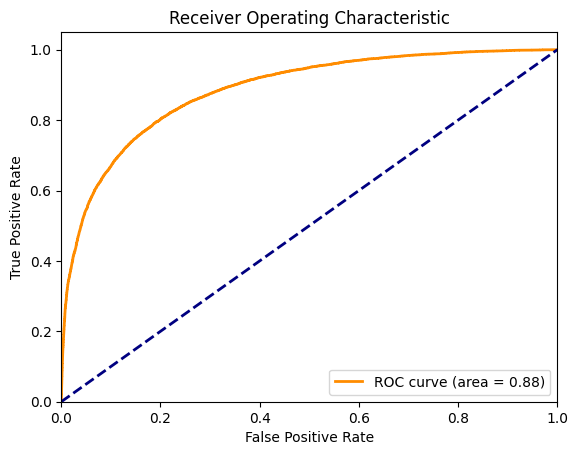

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you've trained your model using the function model_train()

# Make predictions on the validation set
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val_tensor).numpy().flatten()

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_val_tensor.numpy(), y_pred_val)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Pass the test tensor through the trained model to get the predicted probabilities

with torch.no_grad():
    model.eval()
    y_pred_prob = model(test_tensor).numpy().flatten()

# Create a DataFrame containing IDs and predicted probabilities
submission_df = pd.DataFrame({'id': ids, 'Exited': y_pred_prob})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [23]:
print(np.unique(y_pred_prob))

[0.]
